# PM2.5台灣

<a id="load_data"></a>
## 上傳台灣2015一整年空氣監測資料 

### 步驟1: 將2015空氣監控資料，上傳至bluemix

In [1]:
def set_hadoop_config(credentials):
    prefix = "fs.swift.service." + credentials['name'] 
    hconf = sc._jsc.hadoopConfiguration()
    hconf.set(prefix + ".auth.url", credentials['auth_url']+'/v3/auth/tokens')
    hconf.set(prefix + ".auth.endpoint.prefix", "endpoints")
    hconf.set(prefix + ".tenant", credentials['project_id'])
    hconf.set(prefix + ".username", credentials['user_id'])
    hconf.set(prefix + ".password", credentials['password'])
    hconf.setInt(prefix + ".http.port", 8080)
    hconf.set(prefix + ".region", credentials['region'])
    hconf.setBoolean(prefix + ".public", True)

### 步驟2: 將上傳資料與目前機器建立連結 `Insert to code` (畫面的右邊)

In [2]:
credentials_3 = {
  'auth_url':'https://identity.open.softlayer.com',
  'project':'object_storage_46719cd2_5b49_4783_8b86_f8a11f0314d4',
  'project_id':'646b1215221e4e7d8254de7bdf43bf1f',
  'region':'dallas',
  'user_id':'e0e7b9afb0884dfc8639dbf8606db94c',
  'domain_id':'a299c7413da54b60925ac070303b298e',
  'domain_name':'1159491',
  'username':'admin_ac4deff35b52ba280c7b60966e456e345cd3f69c',
  'password':"""jbE.e.rL^P9Z.9MC""",
  'filename':'pm2.5Taiwan.csv',
  'container':'notebooks',
  'tenantId':'sabe-89ac5efdbd68bd-a6554b527697'
}

### 步驟3: 將我們存放於open stack的資料集取名

In [3]:
credentials_3['name'] = 'pm25'
set_hadoop_config(credentials_3)

Now you can access the data by using the preconfigured `SparkContext` function in your notebook. 

First create a resilient distributed dataset ([`RDD`](https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds)) of the raw data file. You can refer to it by using a URI of the form:

```
swift://container_name.name/object_name
```

If you didn't define a container name, at the time you created the Object Storage instance, the default container name that is used is `notebooks`. In this case, you can run the next code cell as it stands. Otherwise, change the container name. For `name` insert the Hadoop configuration name you defined, for example, `keystone`.

In [4]:
weather = sc.textFile("swift://notebooks.pm25/pm2.5Taiwan.csv")

### 步驟4: 試試看是否成功上傳  (使用count( ), first( ), collect( ), take( ) )

In [6]:
print weather.count()
print weather.first()

465318
日期,測站,測項,00,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23


In [7]:
lis = weather.take(5)
for x in lis:
 print x

日期,測站,測項,00,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23
2015/01/01,龍潭,AMB_TEMP,14,14,14,13,13,13,12,12,13,14,14,14,14,14,13,13,12,11,11,11,11,11,11,11
2015/01/01,龍潭,CO,0.69,0.72,0.69,0.64,0.54,0.47,0.45,0.48,0.51,0.54,0.54,0.5,0.47,0.38,0.36,0.35,0.34,0.37,0.34,0.29,0.26,0.22,0.19,0.18
2015/01/01,龍潭,NO,0.3,0.1,0.6,2,2,1.9,2.2,3.1,3.7,4.3,4.3,4.5,3.3,4.1,3.1,3.6,3.6,2.8,2.8,2.5,2.2,1.4,2.1,2
2015/01/01,龍潭,NO2,11,9.6,8.7,9.1,9.6,9.9,11,13,11,12,12,11,11,9.9,9.9,10,11,13,11,10,8.2,7.3,6.5,5.5


# 練習1: 讓我們求取2015年，大里每小時的平均pm25數值。
## 注意事項：
1. 資料分割：原始資料每一行為一個觀測值，我們必須將資料進行分割，才能逐一計算與進行操作。
2. 資料清洗：在氣象局的原始資料裡，有些數值由於當初偵測時有異常，所以會加註特別符號如\*\#等特殊符號，這些數值我們必須先經過前處理，我們才能進行算術運算。
3. 資料選擇：將大里資料挑選出來
4. 產生key-value，也就是(小時,pm25值)
5. 利用flatMap(), reduceByKey(), groupByKey()，將不同日期但相同時間的pm25值收集起來。
6. 計算平均值, 標準差, 最大最小值。


### 步驟一：資料分割 (使用map () 與 split( ))

In [8]:
weatherParse = weather.map(lambda line : line.split(","))
r = weatherParse.take(5)

for x in r:
    for i in range(len(x)):
        print x[i],
    print ""

日期 測站 測項 00 01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 
2015/01/01 龍潭 AMB_TEMP 14 14 14 13 13 13 12 12 13 14 14 14 14 14 13 13 12 11 11 11 11 11 11 11 
2015/01/01 龍潭 CO 0.69 0.72 0.69 0.64 0.54 0.47 0.45 0.48 0.51 0.54 0.54 0.5 0.47 0.38 0.36 0.35 0.34 0.37 0.34 0.29 0.26 0.22 0.19 0.18 
2015/01/01 龍潭 NO 0.3 0.1 0.6 2 2 1.9 2.2 3.1 3.7 4.3 4.3 4.5 3.3 4.1 3.1 3.6 3.6 2.8 2.8 2.5 2.2 1.4 2.1 2 
2015/01/01 龍潭 NO2 11 9.6 8.7 9.1 9.6 9.9 11 13 11 12 12 11 11 9.9 9.9 10 11 13 11 10 8.2 7.3 6.5 5.5 


### 步驟二：將大里站資料從全部資料集中挑選出來 (filter)

須留意unicode與string的差別,  u'大里'

In [9]:
wea_dali = weatherParse.filter(lambda x: x[1] == u'大里' and x[2]== "PM2.5")
lis = wea_dali.take(50)
for x in lis:
    for i in range(len(x)):
        print x[i],
    print 


2015/01/01 大里 PM2.5 53 55 58 53 43 36 35 42 55 64 65 59 52 44 47 41 43 40 42 35 28 20 18 16
2015/01/02 大里 PM2.5 21 22 26 23 20 18 15 21 21 25 29 32 34 29 32 39 51 51 47 43 43 48 47 53
2015/01/03 大里 PM2.5 48 48 43 38 37 36 37 34 37 46 64 77 83 75 68 69 64 65 59 66 71 66 57 48
2015/01/04 大里 PM2.5 60 56 53 43 53 53 52 44 44 50 49 51 45 42 40 38 36 43 51 63 68 72 66 58
2015/01/05 大里 PM2.5 48 42 42 34 34 28 34 35 45 47 54 46 35 19 16 21 24 28 37 52 60 62 64 61
2015/01/06 大里 PM2.5 59 40 34 25 27 29 26 33 42 47 38 24 14 8 17 30 51 62 68 83 83 96 103 110
2015/01/07 大里 PM2.5 117 110 97 68 47 39 34 27 22 15 14  23 18 16 12 10 6 5 9 15 21 23 15
2015/01/08 大里 PM2.5 7 9 13 18 11 12 17 29 34 39 41 46 46 44 43 39 41 46 47 48 47 47 43 33
2015/01/09 大里 PM2.5 35 34 37 30 25 25 22 21 18 20 14 12 21 31 44 46 52 44 39 37 43 43 42 39
2015/01/10 大里 PM2.5 38 33 31 24 20 19 22 31 31 45 48 49 38 39 43 46 43 36 33 29 37 34 39 33
2015/01/11 大里 PM2.5 37 41 43 43 27 22 26 34 39 37 51 53 61 56 48 43 37 43 43 48 54 5

### 步驟三：資料清洗 (使用 map(), str.strip())
#### 在氣象局的原始資料裡，有些數值由於當初偵測時有異常，所以會加註特別符號如\*\#等特殊符號，或者沒有取到數值為一空值，這些數值我們必須先經過前處理，我們才能進行算術運算。
1. ```2015/01/29 大里 PM2.5 14 14 12 7 1 0 4 6 12 16 15  52x 38x 30 29 27 29 24 24 21 19 19 23```
2. ```2015/01/16 大里 PM2.5 16 15 17 16 16 13 5 10 14 30 30 25 -4# 22 23 30 33 40 43 45 37 34 38 43``` 

In [10]:
def strip_symbol(x):
    for i in range(len(x)):
        x[i] = x[i].strip("-*#x") # remove non-digits
        if x[i]=="": x[i]="0"
    return x

wea_dali = wea_dali.map(strip_symbol)


### 步驟四：key value pair的產生 (重要的操作概念)
*將每小時資料轉成(小時,pm數值)，以求取每小時的平均值。

例如：
    2015/01/01 大里 PM2.5 53 55 58 53 43 36 35 42 55 64 65 59 52 44 47 41 43 40 42 35 28 20 18 16
    --> [(3, 53) (4, 55) (5, 58) (6, 53) (7, 43) (8, 36) (9, 35) (10, 42) (11, 55) (12, 64) (13, 65) (14, 59) (15, 52) (16, 44) (17, 47) (18, 41) (19, 43) (20, 40) (21, 42) (22, 35) (23, 28) (24, 20) (25, 18) (26, 16)]


In [24]:
for i in wea_dali.first():
    print i,

2015/01/01 大里 PM2.5 53 55 58 53 43 36 35 42 55 64 65 59 52 44 47 41 43 40 42 35 28 20 18 16


In [12]:
def hourKeyGen(x):
    hourkeypair = []
    for i in range(3,27):
        hourkeypair.append((i,float(x[i])))
    return hourkeypair

wea_dali_byHourkey = wea_dali.map(hourKeyGen)

for i in wea_dali_byHourkey.first():
    print i,

(3, 53.0) (4, 55.0) (5, 58.0) (6, 53.0) (7, 43.0) (8, 36.0) (9, 35.0) (10, 42.0) (11, 55.0) (12, 64.0) (13, 65.0) (14, 59.0) (15, 52.0) (16, 44.0) (17, 47.0) (18, 41.0) (19, 43.0) (20, 40.0) (21, 42.0) (22, 35.0) (23, 28.0) (24, 20.0) (25, 18.0) (26, 16.0)


### 步驟五： 利用flatMap(), reduceByKey(), groupByKey()，將不同日期但相同時間的pm25值收集起來。(使用flatMap)

In [13]:
def hourKeyGen(x):
    hourkeypair = []
    for i in range(3,27):
        hourkeypair.append((i,float(x[i])))
    return hourkeypair

byHourkey = wea_dali.flatMap(hourKeyGen)
byHourkey.reduceByKey(lambda x,y: x+y).take(10)

[(4, 9382.0),
 (6, 8673.0),
 (8, 8021.0),
 (10, 8604.0),
 (12, 10677.0),
 (14, 11047.0),
 (16, 11188.0),
 (18, 10274.0),
 (20, 10328.0),
 (22, 10700.0)]

### 步驟六： 計算大里區每個小時區間中，平均之pm25數值 (使用reduceByKey)

In [14]:
avg_pm25_hour = byHourkey.reduceByKey(lambda x,y: x+y)
avg_pm25_hour.map(lambda x:(x[0],x[1]/365)).collect()

[(4, 25.704109589041096),
 (6, 23.76164383561644),
 (8, 21.975342465753425),
 (10, 23.572602739726026),
 (12, 29.252054794520546),
 (14, 30.265753424657536),
 (16, 30.65205479452055),
 (18, 28.147945205479452),
 (20, 28.295890410958904),
 (22, 29.315068493150687),
 (24, 29.783561643835615),
 (26, 27.852054794520548),
 (3, 26.953424657534246),
 (5, 25.284931506849315),
 (7, 22.865753424657534),
 (9, 22.24931506849315),
 (11, 26.246575342465754),
 (13, 29.915068493150685),
 (15, 31.52054794520548),
 (17, 27.86849315068493),
 (19, 28.482191780821918),
 (21, 28.482191780821918),
 (23, 30.136986301369863),
 (25, 29.161643835616438)]

### 步驟七： 根據pm25平均濃度，進行排序。使用top( )

In [15]:
avg_pm25_hour = byHourkey.reduceByKey(lambda x,y: x+y)
avg_pm25_hour.map(lambda x:(x[0],x[1]/365.0)).map(lambda x: (x[1],x[0])).top(24)

[(31.52054794520548, 15),
 (30.65205479452055, 16),
 (30.265753424657536, 14),
 (30.136986301369863, 23),
 (29.915068493150685, 13),
 (29.783561643835615, 24),
 (29.315068493150687, 22),
 (29.252054794520546, 12),
 (29.161643835616438, 25),
 (28.482191780821918, 21),
 (28.482191780821918, 19),
 (28.295890410958904, 20),
 (28.147945205479452, 18),
 (27.86849315068493, 17),
 (27.852054794520548, 26),
 (26.953424657534246, 3),
 (26.246575342465754, 11),
 (25.704109589041096, 4),
 (25.284931506849315, 5),
 (23.76164383561644, 6),
 (23.572602739726026, 10),
 (22.865753424657534, 7),
 (22.24931506849315, 9),
 (21.975342465753425, 8)]

### 步驟八： 計算每個時間點的統計值，例如最大值、最小值、平均值、標準差(使用 groupByKey()與mapValues())

In [16]:
import numpy as np

def hourKeyGen(x):
    hourkeypair = []
    for i in range(3,27):
        hourkeypair.append((int(i),float(x[i])))
    return hourkeypair

hour_stat_list = byHourkey.groupByKey().mapValues(list).collect()

for i in sorted(hour_stat_list):
    print i[0],max(i[1]),min(i[1]),np.mean(i[1]),np.var(i[1])

3 117.0 0.0 26.9534246575 382.022488272
4 110.0 0.0 25.704109589 362.937106399
5 107.0 0.0 25.2849315068 354.746211297
6 102.0 0.0 23.7616438356 330.055515106
7 98.0 0.0 22.8657534247 310.538142241
8 88.0 0.0 21.9753424658 299.865145431
9 96.0 0.0 22.2493150685 273.962499531
10 102.0 0.0 23.5726027397 286.573495965
11 109.0 0.0 26.2465753425 311.024132107
12 114.0 0.0 29.2520547945 361.739208107
13 114.0 0.0 29.9150684932 394.806485269
14 117.0 0.0 30.2657534247 407.893758679
15 112.0 0.0 31.5205479452 404.748207919
16 103.0 0.0 30.6520547945 385.361125915
17 94.0 0.0 27.8684931507 346.448459373
18 104.0 0.0 28.1479452055 354.97537249
19 93.0 0.0 28.4821917808 297.400367799
20 90.0 0.0 28.295890411 303.534366673
21 88.0 0.0 28.4821917808 299.48255958
22 99.0 0.0 29.3150684932 342.484293488
23 101.0 0.0 30.1369863014 365.712741603
24 100.0 0.0 29.7835616438 375.309318822
25 107.0 0.0 29.1616438356 390.530035654
26 110.0 0.0 27.8520547945 368.131536874


# 練習2: 請求取2015年，全國pm2.5最高的前十個工作站測點以及其日期。

In [17]:
### weatherParse 為原始資料集
pm25_data_set = weatherParse.filter(lambda x: x[2]=="PM2.5")

### 資料清洗
def strip_symbol(x):
    for i in range(len(x)):
        #x[i] = x[i].strip("-*#x") # remove non-digits
        if "#" in x[i]:x[i]="0"
        if "*" in x[i]:x[i]="0"
        if "x" in x[i]:x[i]="0"
        if "-" in x[i]:x[i]="0"
        if x[i]=="": x[i]="0"
    return x

clean_pm25_data_set = pm25_data_set.map(strip_symbol)
#clean_pm25_data_set.take(2)

In [18]:
def date_location_time (x):
    date_loc_time_measure = []
    for i in range(3,27):
        date_loc_time_string = x[0]+x[1]+"_"+str(i)
        date_loc_time_measure.append((date_loc_time_string,int(x[i])))
    return date_loc_time_measure

top10pm25 = clean_pm25_data_set.flatMap(date_location_time).map(lambda x: (x[1],x[0])).top(10)    

for i in top10pm25:
    print i[0],i[1],
    print ""

319 2015/04/18埔里_24 
301 2015/01/01馬公_4 
296 2015/01/01馬公_3 
238 2015/04/18埔里_25 
238 2015/01/06金門_14 
213 2015/01/06金門_13 
196 2015/05/11朴子_24 
196 2015/01/03三義_25 
193 2015/05/11朴子_23 
189 2015/01/06金門_8 


In [19]:
precTop10=[]
stationsTop10=[]
for result in top10pm25:
    precTop10.append(result[0])
    stationsTop10.append(result[1])

Plot your results.

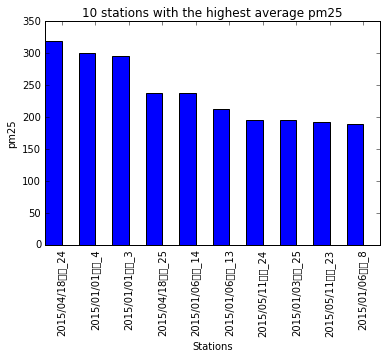

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

N = 10
index = np.arange(N)  
bar_width = 0.5

plt.bar(index, precTop10, bar_width,
                 color='b')
plt.xlabel('Stations')
plt.ylabel('pm25')
plt.title('10 stations with the highest average pm25')
plt.xticks(index + bar_width, stationsTop10, rotation=90)
plt.show()

# 練習3: 請算算看2015全國哪個測站，紫爆天數最多？
### 假設當日平均值大於60，則算該日該地區紫爆


In [22]:
pm25_data_set = weatherParse.filter(lambda x: x[2]=="PM2.5")

### 資料清洗
def strip_symbol(x):
    for i in range(len(x)):
        #x[i] = x[i].strip("-*#x") # remove non-digits
        if "#" in x[i]:x[i]="0"
        if "*" in x[i]:x[i]="0"
        if "x" in x[i]:x[i]="0"
        if "-" in x[i]:x[i]="0"
        if x[i]=="": x[i]="0"
    return x

def toFloat(x):
    location = x[1]
    del x[0:3]
    for i in range(len(x)):
        x[i]=float(x[i])
    return (location, sum(x)/len(x))

clean_pm25_data_set = pm25_data_set.map(strip_symbol)
Worst = clean_pm25_data_set.map(toFloat).filter(lambda x:x[1]>60).
\groupByKey().mapValues(list)\
.map(lambda x:(x[0],len(x[1]))).sortBy(lambda x:x[1], ascending=False).collect()

for loc in Worst:
    print loc[0],loc[1],
    print ""




竹山 28 
斗六 28 
崙背 25 
金門 21 
善化 20 
埔里 18 
復興 17 
左營 17 
橋頭 16 
小港 15 
嘉義 14 
楠梓 13 
麥寮 13 
大里 13 
二林 13 
忠明 12 
鳳山 12 
大寮 12 
仁武 12 
臺西 11 
西屯 10 
馬祖 10 
前鎮 10 
林園 10 
安南 9 
屏東 9 
臺南 9 
新營 9 
新港 8 
潮州 8 
南投 8 
前金 8 
線西 7 
彰化 7 
朴子 6 
桃園 4 
萬華 4 
新莊 4 
頭份 4 
沙鹿 4 
古亭 3 
美濃 3 
中山 3 
苗栗 3 
林口 3 
新店 2 
松山 2 
平鎮 2 
龍潭 2 
永和 2 
竹東 2 
三重 2 
基隆 2 
大園 1 
中壢 1 
觀音 1 
土城 1 
湖口 1 
新竹 1 
豐原 1 
士林 1 
萬里 1 
板橋 1 
